# Exploratory Data Analysis on Wind, Tide, Water fluxes, and Nutrient Pulses in summer 2020

(1) This notebook contains data analysis and visualization on wind, tide, and nutrient pulses
(2) Firstly, the NaNs in hourly wind speed and direction dataset were filled using 'ffill' method
(3) Time series wind speed data were plotted using 'scatter' where the color was coded using wind direction, then a circular colormap was used
(4) Wind quiver function was called to plot the wind vector that have both wind speed and direction
(5) Significant wind speed and significant tide height were defined using a threshold that is higher than 68 percentile of the normal distribution; nutrient pulses were defined using a threshold that is higher than 2 umol/L or using climatological mean + 1*SD ([see this notebook for details](https://github.com/Zhu-Yifan/Lafayette_River_Time_Series_Analysis/blob/master/notebooks/Chesapeake_Bay_Program_Water_Quality_EDA.ipynb) ) using Chesapeake Bay Program long-term water quality data
(6) DIN was calculated using the sum of NH4 and NO3, because sometimes the response of NH4 and NO3 to wind/tide is not coupled
(7) Water fluxes were calculated in MATLAB (so the details are not shown here)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import os
from scipy.stats import pearsonr
from datetime import datetime

In [2]:
# import wind data
infile = '../data/external/Wind_hourly_2020.csv'
data = pd.read_csv(infile, usecols=[0, 1, 2, 3], parse_dates=['DateTime'], infer_datetime_format=True, sep=',')
# select the dateTime range
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data[data.DateTime > pd.Timestamp('2020-05-31 23:59:00')]
data = data[data.DateTime < pd.Timestamp('2020-10-06 00:59:00')]
data

DateTime  WindSpeed  WindDirection  WindGustSpeed
48   2020-06-01 00:59:00        0.0            0.0            NaN
49   2020-06-01 01:59:00        7.0          110.0            NaN
50   2020-06-01 02:59:00        0.0            0.0            NaN
51   2020-06-01 03:59:00        5.0          280.0            NaN
52   2020-06-01 04:59:00        8.0          340.0            NaN
...                  ...        ...            ...            ...
3091 2020-10-05 19:59:00        0.0            0.0            NaN
3092 2020-10-05 20:59:00        0.0            0.0            NaN
3093 2020-10-05 21:59:00        0.0            0.0            NaN
3094 2020-10-05 22:59:00        0.0            0.0            NaN
3095 2020-10-05 23:59:00        0.0            0.0            NaN

[3048 rows x 4 columns]

In [3]:
# fill data gaps
data['WindSpeed'].fillna(method='ffill',inplace=True)
data['WindDirection'].fillna(method='ffill',inplace=True)
# create vector
cos_WindDir = np.deg2rad(data['WindDirection'])
sin_WindDir= np.deg2rad(data['WindDirection'])
U_wind=data['WindSpeed']*0.44704*np.cos(cos_WindDir)
V_wind=data['WindSpeed']*0.44704*np.sin(sin_WindDir)

In [4]:
# load in the mooring data file where it contains the tide height in column 'Depth_meter_NY'
infile = '../data/processed/Cleaned_mooring_2020.csv'
# colnames = ['Temp_AC','Sal_AC','Fluor_AC','Chl_AC','Temp_NY','Sal_NY','Fluor_NY','Chl_NY','Temp_NY_btm','Sal_NY_btm','Fluor_NY_btm','Chl_NY_btm','DateTime_NY']
data_YSI = pd.read_csv(infile, usecols=['Date_Time_NY','Depth_meter_NY'],parse_dates=['Date_Time_NY'], infer_datetime_format=True, sep = ',')
data_YSI

Date_Time_NY  Depth_meter_NY
0     2020-06-01 00:01:00            0.40
1     2020-06-01 00:16:00            0.44
2     2020-06-01 00:31:00            0.48
3     2020-06-01 00:46:00            0.52
4     2020-06-01 01:01:00            0.57
...                   ...             ...
12187 2020-10-05 22:46:00            1.12
12188 2020-10-05 23:01:00            1.15
12189 2020-10-05 23:16:00            1.18
12190 2020-10-05 23:31:00            1.20
12191 2020-10-05 23:46:00            1.22

[12192 rows x 2 columns]

In [5]:
data_YSI['Depth_meter_NY'].fillna(method='bfill',inplace=True)

In [6]:
# Load water flux data (the flux calculations were done in MATLAB and exported here)
infile = '../data/processed/Waterflux_2020.csv'
Waterflux = pd.read_csv(infile, usecols=[0, 1], parse_dates=['DateTime_WF_NY_2020'], infer_datetime_format=True, sep=',')
Waterflux = Waterflux[Waterflux.DateTime_WF_NY_2020 > pd.Timestamp('2020-05-31 23:59:00')]
Waterflux = Waterflux[Waterflux.DateTime_WF_NY_2020 < pd.Timestamp('2020-10-06 00:59:00')]
Waterflux

DateTime_WF_NY_2020   WaterFlux
192   2020-06-01 00:01:00  298.898599
193   2020-06-01 00:16:00  339.685887
194   2020-06-01 00:31:00  381.614007
195   2020-06-01 00:46:00  405.232981
196   2020-06-01 01:01:00  429.503942
...                   ...         ...
12383 2020-10-05 23:46:00   98.736043
12384 2020-10-06 00:01:00   43.228609
12385 2020-10-06 00:16:00  -12.366610
12386 2020-10-06 00:31:00  -56.769698
12387 2020-10-06 00:46:00 -112.033509

[12196 rows x 2 columns]

In [7]:
# Load nutrient data, there are 3 depths (surface, intermediate, and bottom depth), 'D3_NH4_NY' means NH4 concentration at the 3rd depth, which is the bottom depth
infile = '../data/processed/Nutrient_2020_V4.csv'
nuts = pd.read_csv(infile, usecols=['Date_Time_NYCC', 'D2_N+N_NY', 'D3_N+N_NY','D2_NH4_NY', 'D3_NH4_NY'], parse_dates=['Date_Time_NYCC'], infer_datetime_format=True, sep=',')

# select the dateTime range
nuts = nuts[nuts.Date_Time_NYCC > pd.Timestamp('2020-05-31 23:59:00')]
nuts = nuts[nuts.Date_Time_NYCC < pd.Timestamp('2020-10-06 00:59:00')]
nuts

Date_Time_NYCC  D2_N+N_NY  D3_N+N_NY  D2_NH4_NY  D3_NH4_NY
0  2020-06-01 13:40:00       4.18       2.50       5.86       6.05
1  2020-06-03 13:25:00       0.52       0.38       5.27       5.54
2  2020-06-05 13:47:00       1.06       1.08       5.05       4.77
3  2020-06-08 13:36:00       0.87       1.41       4.74       5.32
4  2020-06-10 14:32:00       0.88       1.04       5.92       5.44
5  2020-06-12 12:25:00        NaN       3.26       5.49       4.57
6  2020-06-15 12:18:00       2.30       2.28       2.90       4.99
7  2020-06-17 12:16:00        NaN       2.91      11.44      11.59
8  2020-06-19 12:23:00       3.19       3.58      13.42      14.34
9  2020-06-22 13:14:00        NaN       3.55        NaN       0.01
10 2020-06-24 14:09:00       2.62       3.46       0.01       0.01
11 2020-06-26 13:21:00        NaN       3.69       1.33       1.64
12 2020-06-29 13:36:00       1.44       1.71       1.07       1.02
13 2020-07-01 13:30:00        NaN        NaN       0.56       0.48
14 2020-07-03 14:32:00       0.54       1.29       8.87      13.41
15 2020-07-06 13:32:00        NaN        NaN       9.34      10.42
16 2020-07-08 13:49:00       0.36       0.61       9.10      10.12
17 2020-07-10 13:05:00        NaN        NaN       6.17       5.91
18 2020-07-13 13:48:00       0.26       0.39       9.23      10.57
19 2020-07-15 13:42:00        NaN        NaN       8.84       9.59
20 2020-07-17 13:55:00       0.57       0.67      11.95      15.44
21 2020-07-20 13:32:00        NaN        NaN      13.32      14.44
22 2020-07-22 13:23:00       0.30       0.42      13.20      13.57
23 2020-07-24 13:23:00        NaN        NaN        NaN        NaN
24 2020-07-26 13:44:00        NaN        NaN        NaN        NaN
25 2020-07-28 13:13:00        NaN       0.25        NaN        NaN
26 2020-07-30 13:35:00        NaN        NaN        NaN        NaN
27 2020-08-01 13:45:00       0.14       0.51       8.76      13.14
28 2020-08-04 13:15:00        NaN        NaN      10.83      10.95
29 2020-08-06 13:30:00       0.28       0.53        NaN       1.34
30 2020-08-08 13:43:00       0.22       0.37       0.95       2.38
31 2020-08-10 13:24:00       0.35       0.34       0.67       0.97
32 2020-08-12 13:16:00       0.79       1.02        NaN        NaN
33 2020-08-14 13:31:00       0.14       0.35       6.24       7.66
34 2020-08-16 13:08:00       0.14       0.14       5.33       6.43
35 2020-08-18 13:27:00       0.14       0.14       0.91       3.01
36 2020-08-20 13:27:00       0.23       0.37       1.41       2.43
37 2020-08-22 13:35:00       1.45       1.12       5.51       5.51
38 2020-08-24 13:36:00       3.82       4.50       3.53       3.94
39 2020-08-26 13:37:00       4.53       5.79       1.37       1.14
40 2020-08-28 13:49:00       2.62       6.87       1.61       5.95
41 2020-08-31 14:10:00       1.45       8.75       0.89       6.60
42 2020-09-02 13:12:00       1.74       5.84       0.58       6.18
43 2020-09-04 13:28:00       1.70       2.31       0.78       1.29
44 2020-09-07 13:24:00       5.03       5.82       0.83       2.05
45 2020-09-09 13:24:00       4.74       5.22       1.56       2.67
46 2020-09-14 13:15:00       3.91       5.82       4.52      10.44
47 2020-09-16 13:01:00       3.85       4.26       5.43       5.67
48 2020-09-18 13:08:00       6.14       6.46       7.26       7.98
49 2020-09-23 13:10:00      10.39      10.92       2.77       3.13
50 2020-09-30 13:22:00       7.09       7.41       1.27       2.33
51 2020-10-05 13:22:00        NaN        NaN        NaN        NaN

In [8]:
# import extracted water level (tide height) 2020 data
infile = '../data/processed/Extract_water_level_NY_2020.csv'
WL = pd.read_csv(infile,  parse_dates=['Date_NY_2020_0day','Date_NY_2020_1day','Date_NY_2020_2day'], infer_datetime_format=True, sep=',')
WL

Date_NY_2020_0day   Date_NY_2020_1day   Date_NY_2020_2day  tide_0day  \
0    2020-06-01 00:01:00 2020-05-31 00:01:00 2020-05-30 00:01:00       0.40   
1    2020-06-01 00:16:00 2020-05-31 00:16:00 2020-05-30 00:16:00       0.44   
2    2020-06-01 00:31:00 2020-05-31 00:31:00 2020-05-30 00:31:00       0.48   
3    2020-06-01 00:46:00 2020-05-31 00:46:00 2020-05-30 00:46:00       0.52   
4    2020-06-01 01:01:00 2020-05-31 01:01:00 2020-05-30 01:01:00       0.57   
...                  ...                 ...                 ...        ...   
4987 2020-10-07 22:46:00 2020-10-06 22:46:00 2020-10-05 22:46:00       0.54   
4988 2020-10-07 23:01:00 2020-10-06 23:01:00 2020-10-05 23:01:00       0.58   
4989 2020-10-07 23:16:00 2020-10-06 23:16:00 2020-10-05 23:16:00       0.62   
4990 2020-10-07 23:31:00 2020-10-06 23:31:00 2020-10-05 23:31:00       0.66   
4991 2020-10-07 23:46:00 2020-10-06 23:46:00 2020-10-05 23:46:00       0.69   

      tide_1day  tide_2day  
0          0.60       0.79  
1          0.65       0.85  
2          0.70       0.89  
3          0.75       0.92  
4          0.80       0.96  
...         ...        ...  
4987       0.88       1.12  
4988       0.91       1.15  
4989       0.94       1.18  
4990       0.97       1.20  
4991       0.99       1.22  

[4992 rows x 6 columns]

In [9]:
# import extracted water flux 2020 data
infile = '../data/processed/Extract_waterflux_2020.csv'
flux = pd.read_csv(infile,  parse_dates=['Datetime_0day','Datetime_1day','Datetime_2day'], infer_datetime_format=True, sep=',')
flux

Datetime_0day       Datetime_1day       Datetime_2day  \
0    2020-06-01 00:01:00 2020-05-31 00:01:00 2020-05-30 00:01:00   
1    2020-06-01 00:16:00 2020-05-31 00:16:00 2020-05-30 00:16:00   
2    2020-06-01 00:31:00 2020-05-31 00:31:00 2020-05-30 00:31:00   
3    2020-06-01 00:46:00 2020-05-31 00:46:00 2020-05-30 00:46:00   
4    2020-06-01 01:01:00 2020-05-31 01:01:00 2020-05-30 01:01:00   
...                  ...                 ...                 ...   
4987 2020-10-07 22:46:00 2020-10-06 22:46:00 2020-10-05 22:46:00   
4988 2020-10-07 23:01:00 2020-10-06 23:01:00 2020-10-05 23:01:00   
4989 2020-10-07 23:16:00 2020-10-06 23:16:00 2020-10-05 23:16:00   
4990 2020-10-07 23:31:00 2020-10-06 23:31:00 2020-10-05 23:31:00   
4991 2020-10-07 23:46:00 2020-10-06 23:46:00 2020-10-05 23:46:00   

      WaterFlux_extract_0day  WaterFlux_extract_1day  WaterFlux_extract_2day  
0                 298.898599              421.794626              491.842734  
1                 339.685887              446.613348              359.345557  
2                 381.614007              451.762299              369.648901  
3                 405.232981              456.911251              258.638029  
4                 429.503942              451.654614              295.170969  
...                      ...                     ...                     ...  
4987              270.077209              279.857533              272.616838  
4988              291.731748              271.164824              229.919269  
4989              303.933474              241.082590              186.621267  
4990              306.374238              199.864048              153.964513  
4991              298.740791              168.766744               98.736043  

[4992 rows x 6 columns]

### plot wind, tide, nutrient, water fluxes

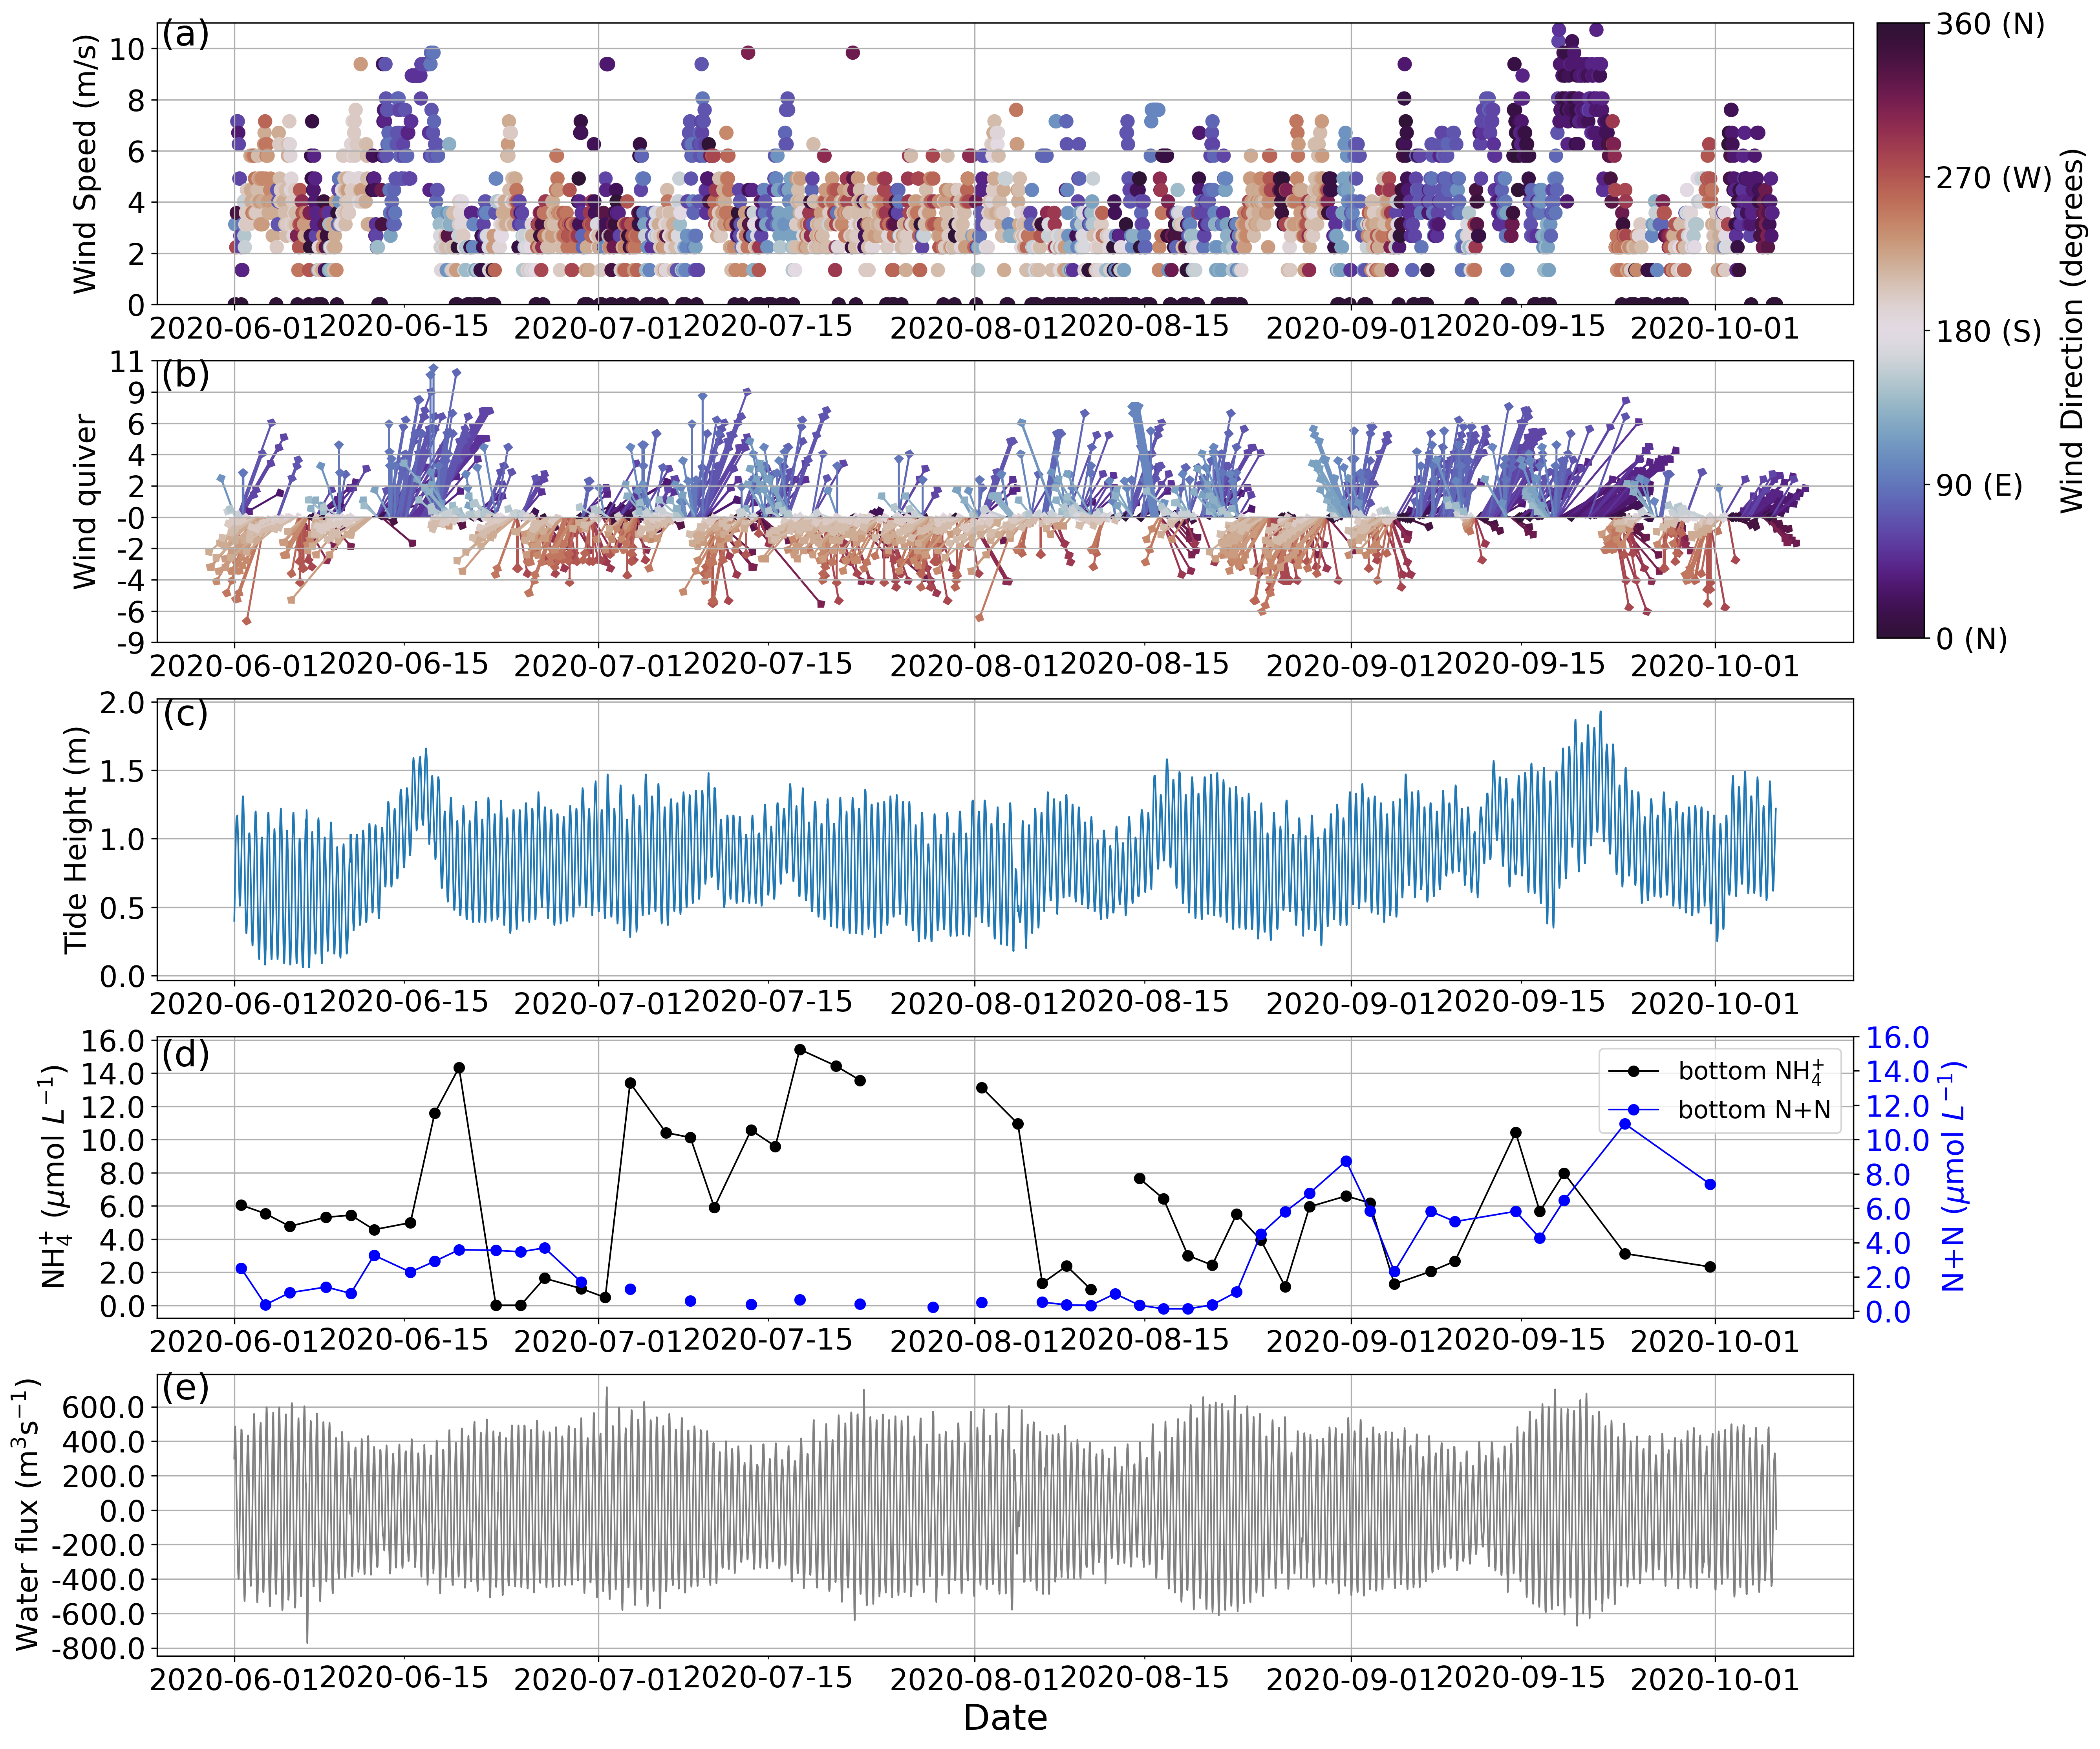

In [10]:
# plot time series data for wind and tide variables
fig, axes = plt.subplots(5, 1, figsize=(20, 18),dpi = 300, sharex=True)
# Using a circular colormap based on wind direction
cmap = plt.colormaps.get_cmap('twilight_shifted')
norm = plt.Normalize(vmin=0, vmax=360)
# Plot the time-series wind speed, using color to indicate direction
scatter=axes[0].scatter(data['DateTime'], data['WindSpeed']*0.44704, c=data['WindDirection'],  s=60, cmap=cmap, norm=norm)
# create a separate axis object for the colorbar
cbar_ax = fig.add_axes([0.88, 0.59, 0.02, 0.29], anchor="C", zorder=20)
# add the colorbar to the figure
cbar = plt.colorbar(scatter, cbar_ax)
# show 5 ticks on the colorbar
cbar.set_ticks([0, 90, 180, 270, 360])
cbar.set_ticklabels(['0 (N)', '90 (E)', '180 (S)', '270 (W)','360 (N)'])
cbar.set_label('Wind Direction (degrees)',fontsize=18)
cbar.ax.tick_params(labelsize=18)
# adjust the subplot and colorbar positions as needed
fig.subplots_adjust(left=0.15, right=0.87, wspace=0.3)
axes[0].set_ylabel('Wind Speed (m/s)',fontsize=18)
axes[0].set_ylim(0,11)
WindSpeed = data['WindSpeed']*0.44704
y_ticks =np.arange(0,np.max(WindSpeed),2)
y_tick_labels = ['{:.0f}'.format(t) for t in y_ticks]
axes[0].set_yticks(y_ticks, y_tick_labels, fontsize = 18)
axes[0].text(mdates.date2num(datetime(2020, 5, 28)), 10.5, "(a)", fontsize=22, ha="center", va="center")
axes[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
date_fmt = mdates.DateFormatter('%Y-%m-%d')
axes[0].xaxis.set_major_formatter(date_fmt)
axes[0].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
month_locator = mdates.MonthLocator()
day_locator = mdates.DayLocator(bymonthday=[1, 15])
axes[0].xaxis.set_major_locator(month_locator)
axes[0].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[0].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[0].grid(True)

# subplot 2
y = np.zeros(len(data['DateTime']))
# Convert wind directions to colors by normalize it unto the color pallet
norm = mcolors.Normalize(vmin=0, vmax=360)
colors = plt.cm.twilight_shifted(norm(data['WindDirection']))
axes[1].quiver(data['DateTime'], y, U_wind, V_wind, color= colors, scale=10, scale_units='xy', width=0.0012, headwidth=5, headlength=2)
# Set y-axis tick labels to correspond to true wind speed
y_ticks = np.arange(-(np.ceil(np.max(y))+0.8), np.ceil(np.max(y))+1.1, 0.2)
y_tick_labels = ['{:.0f}'.format(WindSpeed.max() * t) for t in y_ticks]
axes[1].set_yticks(y_ticks, y_tick_labels, fontsize = 18)
axes[1].set_ylabel('Wind quiver',fontsize=18)
axes[1].text(mdates.date2num(datetime(2020, 5, 28)), 0.9, "(b)", fontsize=22, ha="center", va="center")
axes[1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[1].xaxis.set_major_formatter(date_fmt)
axes[1].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[1].xaxis.set_major_locator(month_locator)
axes[1].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[1].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[1].grid(True)

# subplot 3, Tide height
axes[2].plot(data_YSI['Date_Time_NY'], data_YSI['Depth_meter_NY'], marker ='o', markersize = 0, linestyle='-', linewidth=1)
# overlay with discrete nutrient sampling date
#axes[2].plot(WL['Date_NY_2020_0day'], WL['tide_0day'], marker ='o', markersize = 1, linestyle='-', linewidth=0,color='darkblue')
axes[2].set_ylabel('Tide Height (m)',fontsize=18)
# Set y-axis tick labels to correspond to tide
y_ticks = np.arange(0, np.ceil(np.max(data_YSI['Depth_meter_NY']))+0.5, 0.5)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[2].set_yticks(y_ticks, y_tick_labels, fontsize = 18 )
axes[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[2].xaxis.set_major_formatter(date_fmt)
axes[2].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[2].xaxis.set_major_locator(month_locator)
axes[2].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[2].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[2].text(mdates.date2num(datetime(2020, 5, 28)), 1.9, "(c)", fontsize=22, ha="center", va="center")
axes[2].grid(True)

# subplot 4, nutrient
axes3 = axes[3].twinx() # have two y axis
l1= axes[3].plot(nuts['Date_Time_NYCC'], nuts['D3_NH4_NY'], marker ='o', markersize = 6, linestyle='-', linewidth=1, color='black',label ='bottom NH$_4^{+}$')


axes[3].set_ylabel('NH$_4^{+}$ ($\mu$mol $L^{-1}$)',fontsize=18)
y_ticks = np.arange(0, np.ceil(np.max(nuts['D3_NH4_NY']))+0.5, 2)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[3].set_yticks(y_ticks, y_tick_labels, fontsize=18)

l2= axes3.plot(nuts['Date_Time_NYCC'], nuts['D3_N+N_NY'], marker ='o', markersize = 6, linestyle='-', linewidth=1, color='blue', label='bottom N+N')

axes3.set_ylabel('N+N ($\mu$mol $L^{-1}$)', color='blue', fontsize=18)
y_ticks = np.arange(0, np.ceil(np.max(nuts['D3_NH4_NY']))+2, 2)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes3.set_yticks(y_ticks, y_tick_labels, fontsize=18 )
axes3.tick_params(axis='y', labelcolor='blue')
axes[3].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[3].xaxis.set_major_formatter(date_fmt)
axes[3].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[3].xaxis.set_major_locator(month_locator)
axes[3].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[3].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[3].text(mdates.date2num(datetime(2020, 5, 28)), 15, "(d)", fontsize=22, ha="center", va="center")
# combine the legends for both y-axes
lines, labels = axes[3].get_legend_handles_labels()
lines2, labels2 = axes3.get_legend_handles_labels()
axes[3].legend(lines + lines2, labels + labels2, fontsize=15, loc='upper right')
axes[3].grid(True)

# subplot 5, water fluxes
axes[4].plot(Waterflux['DateTime_WF_NY_2020'], Waterflux['WaterFlux'], marker ='o', markersize = 0, linestyle='-', color='gray',linewidth=1)
# overlay with discrete nutrient sampling date
#axes[4].plot(flux['Datetime_0day'], flux['WaterFlux_extract_0day'], marker ='o', markersize = 1, linestyle='-', color='black',linewidth=0)
axes[4].set_ylabel('Water flux (m$^{3}$s$^{-1}$)',fontsize=18)
# Set y-axis tick labels to correspond to tide
y_ticks = np.arange(-800, 800, 200)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[4].set_yticks(y_ticks, y_tick_labels, fontsize = 18 )
axes[4].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[4].xaxis.set_major_formatter(date_fmt)
axes[4].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[4].xaxis.set_major_locator(month_locator)
axes[4].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[4].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[4].text(mdates.date2num(datetime(2020, 5, 28)), 700, "(e)", fontsize=22, ha="center", va="center")
axes[4].set_xlabel('Date',fontsize=22)
axes[4].grid(True)


# show plot
plt.show()

# Set the directory where the figure will be saved
save_dir = "../figures/"
fig.savefig(os.path.join(save_dir, 'Wind_Tide_nutrient.png'), dpi = 300)

#### Northeaster wind amplify the tide height, south westly wind decrease the tide height

In [11]:
data_YSI= data_YSI.set_index('Date_Time_NY')
data = data.set_index('DateTime')

### Down-sample tide height data to match with hourly frequency and save to .csv file

In [12]:
# make sure wind speed, wind direction, and tide height have the same length by calling 'resample' function
tide_dwsampled = data_YSI['Depth_meter_NY'].resample('H').fillna(method='bfill')
WS_resampled = data['WindSpeed'].resample('H').fillna(method='bfill')
WS_resampled = WS_resampled*0.44704
WD_resampled = data['WindDirection'].resample('H').fillna(method='bfill')

# stack resampled wind speed and wind direction, tide height side by side into PandaFrame
data_combined = pd.concat([WS_resampled,WD_resampled, tide_dwsampled], axis=1,join='outer')
data_combined = data_combined.rename_axis('Datetime')
# Save the combined data to a new CSV file
data_combined.to_csv(r'../data/processed/resampled_tide_wind_data.csv')

### Calculate the correlation between wind speed, wind direction, and tide height
* To see if there are some significant correletion using pearson p_value

In [13]:
# Calculate the Pearson correlation coefficient between wind speed, wind direction, and tide height
corr, p_value = pearsonr(WS_resampled,tide_dwsampled)
print('Pearson correlation coefficient between wind speed and tide height:', corr)
print('p_value is:', p_value)
corr, p_value = pearsonr(WD_resampled,tide_dwsampled)
print('Pearson correlation coefficient between wind direction and tide height:', corr)
print('p_value is:', p_value)

Pearson correlation coefficient between wind speed and tide height: 0.21803522060042252
p_value is: 4.006302376401969e-34
Pearson correlation coefficient between wind direction and tide height: -0.1670357137339314
p_value is: 1.6426082057149643e-20


### The result shows there are significant positive correlation between wind speed and tide height
* Wind direction also impact significantly on tide height



#### Define (1) significant wind speed, (2) significant tide height

In [14]:
# Calculate the 68th percentile for tide, 1 standard deviation of normal distribution
signifit_tide = tide_dwsampled- np.percentile(tide_dwsampled, 68)
signifit_tide[signifit_tide<0] = np.nan

# Calculate the 68th percentile for wind speed
signifit_WS = WS_resampled- np.percentile(WS_resampled, 68)
signifit_WS[signifit_WS<0] = np.nan


In [15]:
# Calculate the Pearson correlation coefficient between wind speed, wind direction, and tide height
corr, p_value = pearsonr(signifit_tide.fillna(0),signifit_WS.fillna(0))
print('Pearson correlation coefficient between wind speed and tide height:', corr)
print('p_value is:', p_value)

Pearson correlation coefficient between wind speed and tide height: 0.3386378210705981
p_value is: 1.1647615228328791e-82


#### Calculate DIN by adding NH4 and NO3

In [16]:
# add columns while avoiding NaNs
DIN = nuts['D3_NH4_NY'].fillna(0) + nuts['D3_N+N_NY'].fillna(0)
# mask values that either NH4 or N+N has NaNs
idx = np.where(nuts['D3_NH4_NY'].isnull() | nuts['D3_N+N_NY'].isnull())  # find NaNs
DIN.array[idx]=np.nan

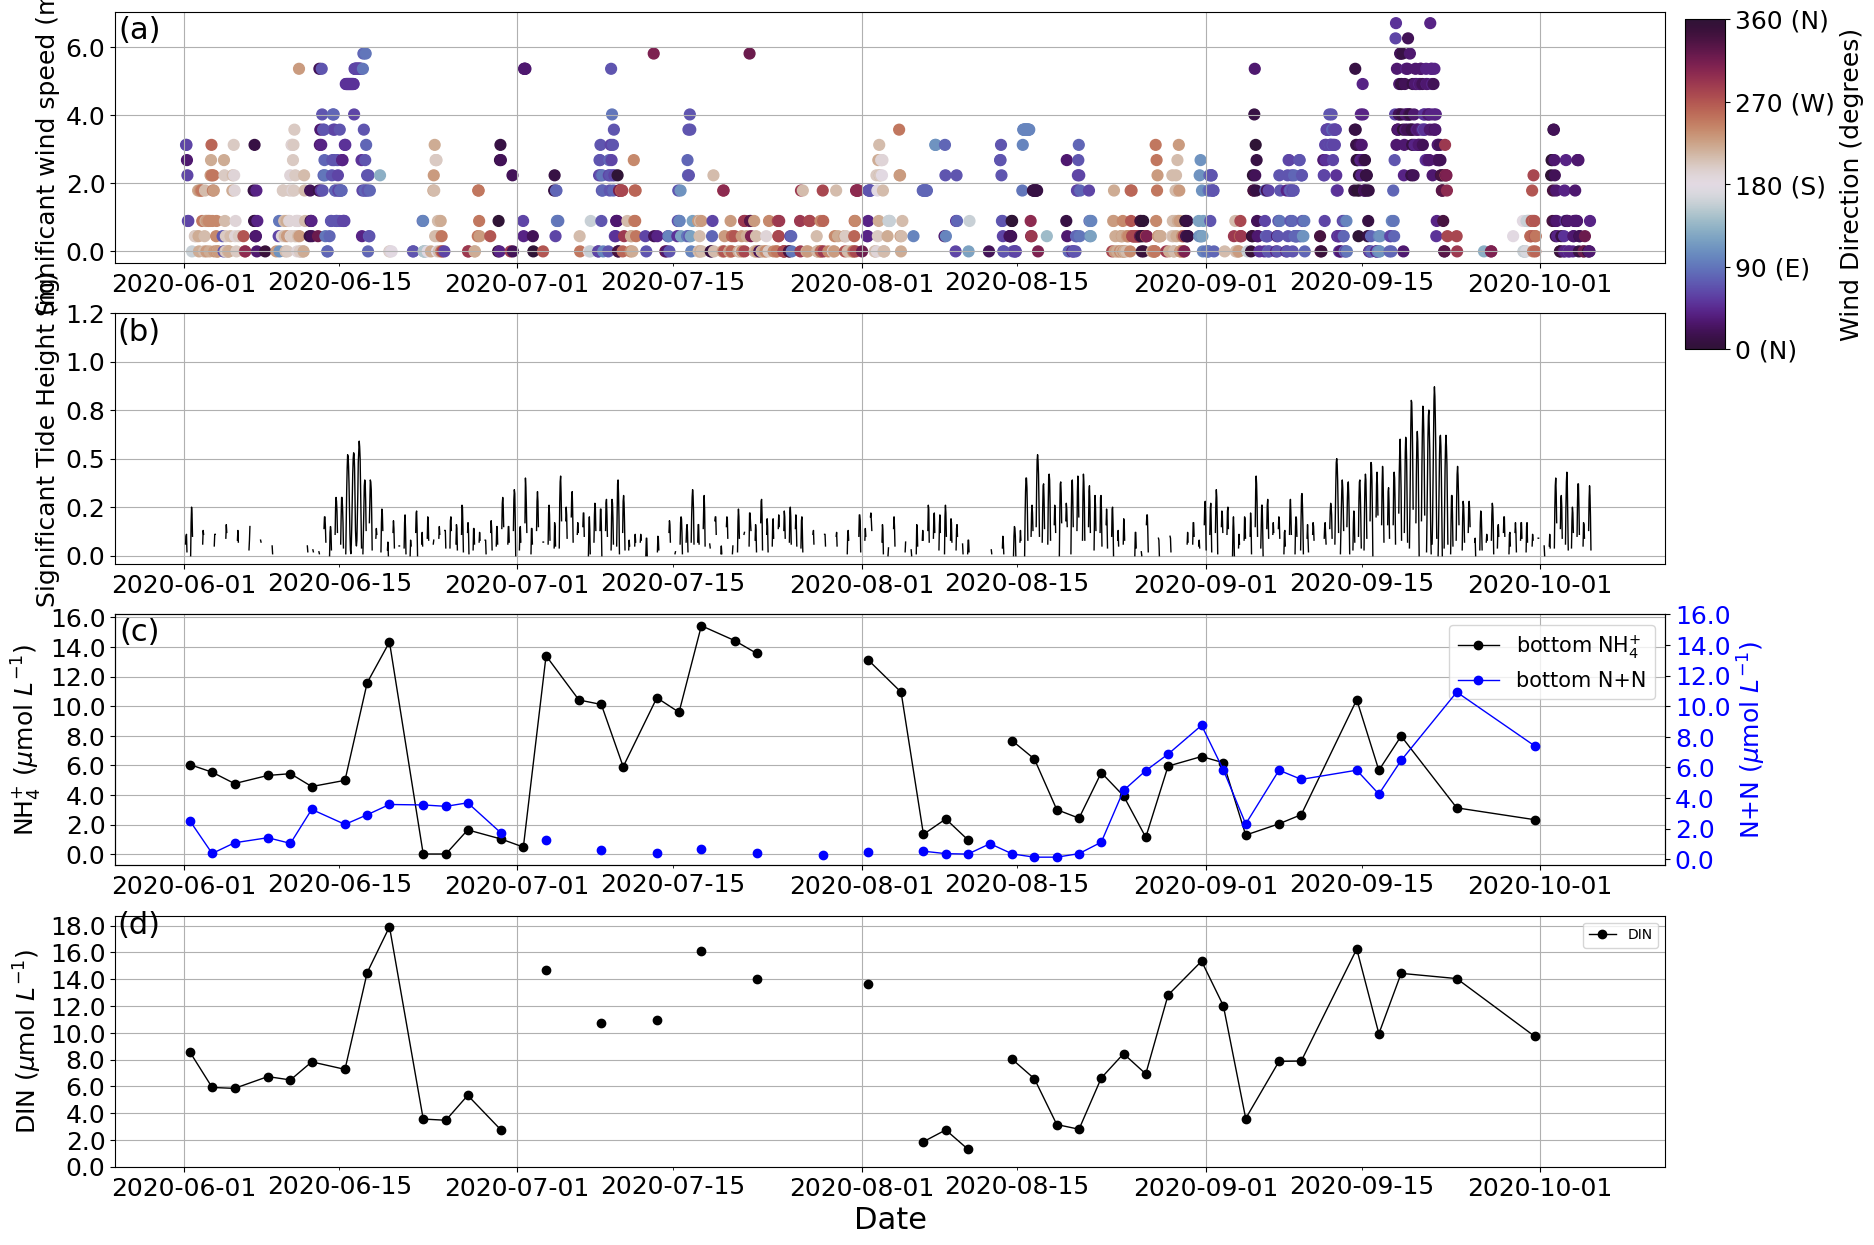

In [17]:
# plot time series data for wind and tide variables
fig, axes = plt.subplots(4, 1, figsize=(20, 15),sharex=True)
# Plot the wind direction data in the bottom subplot, using color to indicate direction
scatter=axes[0].scatter(signifit_WS.index, signifit_WS.array, c=WD_resampled.array,  s=60, cmap=cmap, norm=norm)
# create a separate axis object for the colorbar
cbar_ax = fig.add_axes([0.91, 0.655, 0.02, 0.22], anchor="C", zorder=20)
# add the colorbar to the figure
cbar = fig.colorbar(scatter, cbar_ax)
# show ticks on the colorbar
cbar.set_ticks([0, 90, 180, 270,360])
cbar.set_ticklabels(['0 (N)', '90 (E)', '180 (S)', '270 (W)','360 (N)'])
cbar.set_label('Wind Direction (degrees)',fontsize=18)
cbar.ax.tick_params(labelsize=18)

axes[0].set_ylabel('Significant wind speed (m/s)',fontsize=18)
y_ticks = np.arange(0, np.ceil(np.max(signifit_WS))+0.5, 2)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[0].set_yticks(y_ticks, y_tick_labels, fontsize=18)

axes[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[0].xaxis.set_major_formatter(date_fmt)
axes[0].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[0].xaxis.set_major_locator(month_locator)
axes[0].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[0].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[0].text(mdates.date2num(datetime(2020, 5, 28)), 6.5, "(a)", fontsize=22, ha="center", va="center")
axes[0].grid(True)

# subplot 2
axes[1].plot(signifit_tide.index, signifit_tide.array, marker ='o', markersize = 0, linestyle='-', linewidth=1, color='black')
axes[1].set_ylabel('Significant Tide Height (m)',fontsize=18)
# Set y-axis tick labels to correspond to significant tide
y_ticks = np.arange(0, np.ceil(np.max(signifit_tide))+0.5, 0.25)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[1].set_yticks(y_ticks, y_tick_labels, fontsize=18 )
axes[1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[1].xaxis.set_major_formatter(date_fmt)
axes[1].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[1].xaxis.set_major_locator(month_locator)
axes[1].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[1].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[1].text(mdates.date2num(datetime(2020, 5, 28)), 1.15, "(b)", fontsize=22, ha="center", va="center")
axes[1].grid(True)

# subplot 3
axes2 = axes[2].twinx() # have two y axis
l1= axes[2].plot(nuts['Date_Time_NYCC'], nuts['D3_NH4_NY'], marker ='o', markersize = 6, linestyle='-', linewidth=1, color='black',label ='bottom NH$_4^{+}$')

axes[2].set_ylabel('NH$_4^{+}$ ($\mu$mol $L^{-1}$)',fontsize=18)
y_ticks = np.arange(0, np.ceil(np.max(nuts['D3_NH4_NY']))+0.5, 2)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[2].set_yticks(y_ticks, y_tick_labels, fontsize=18)

l2= axes2.plot(nuts['Date_Time_NYCC'], nuts['D3_N+N_NY'], marker ='o', markersize = 6, linestyle='-', linewidth=1, color='blue', label='bottom N+N')

axes2.set_ylabel('N+N ($\mu$mol $L^{-1}$)', color='blue', fontsize=18)
y_ticks = np.arange(0, np.ceil(np.max(nuts['D3_NH4_NY']))+2, 2)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes2.set_yticks(y_ticks, y_tick_labels, fontsize=18 )
axes2.tick_params(axis='y', labelcolor='blue')
axes[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[2].xaxis.set_major_formatter(date_fmt)
axes[2].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[2].xaxis.set_major_locator(month_locator)
axes[2].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[2].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[2].text(mdates.date2num(datetime(2020, 5, 28)), 15, "(c)", fontsize=22, ha="center", va="center")
# combine the legends for both y-axes
lines, labels = axes[2].get_legend_handles_labels()
lines2, labels2 = axes2.get_legend_handles_labels()
axes[2].legend(lines + lines2, labels + labels2, fontsize=15, loc='upper right')

axes[2].grid(True)

# subplot 4
axes[3].plot(nuts['Date_Time_NYCC'], DIN.array, marker ='o', markersize = 6, linestyle='-', linewidth=1, color='black',label ='DIN')
axes[3].set_xlabel('Date',fontsize=22)
axes[3].set_ylabel('DIN ($\mu$mol $L^{-1}$)',fontsize=18)
y_ticks = np.arange(0, np.ceil(np.max(DIN.array))+0.5, 2)
y_tick_labels = ['{:.1f}'.format(t) for t in y_ticks]
axes[3].set_yticks(y_ticks, y_tick_labels, fontsize = 18 )
axes[3].xaxis.set_major_formatter(date_fmt)
axes[3].xaxis.set_minor_formatter(date_fmt)
# Set the x-axis tick locator to show ticks on the 1st day and 15th day of each month
axes[3].xaxis.set_major_locator(month_locator)
axes[3].xaxis.set_minor_locator(day_locator)
# Set the tick parameters for both the major and minor ticks
plt.setp(axes[3].get_xticklabels(which='both'), rotation=0, ha='center', fontsize=18)
axes[3].text(mdates.date2num(datetime(2020, 5, 28)), 18, "(d)", fontsize=22, ha="center", va="center")
axes[3].legend()
axes[3].grid(True)
# show plot
plt.show()
# Set the directory where the figure will be saved
save_dir = "../figures/"

fig.savefig(os.path.join(save_dir, 'Significant_Wind_Tide_Nutrient.png'), dpi = 300)

* NH4 is more reactive in summer months than NO3, nutrient pulses are primarily in form of NH4 , however, in late Aug and early Sep, nitrification happens where NH4 is converted to NO3.

#### Define nutrient pulses

(1) Method 1—calculate climatological mean and deviation for 20 years historical data at LFA01 from the Chesapeake Bay Monitoring program. Using any data that is higher than mean+1*deviation as nutrients pulses. The standard deviation was very high ([see this notebook for details](https://github.com/Zhu-Yifan/Lafayette_River_Time_Series_Analysis/blob/master/notebooks/Chesapeake_Bay_Program_Water_Quality_EDA.ipynb) )

* The mean+ 1*SD for NH4 at LFA01 is 7.9 uM (4.1+3.8)

(2) Method 2—arbitrarily define nutrient pulses using a threshold such as 2 uM (see below).

In [18]:
# define nutrient pulses using method 2: [N]>2 umol/L
NH4_pulse = nuts['D3_NH4_NY']-2
NO3_pulse = nuts['D3_N+N_NY']-2
